# Enter your name and student ID number in this box.

Use the form of Last Name, First Name, ISU student ID: (Example) DICKERSON, JULIE, 123456789


# HW 3: CIFAR-10 Classification: PyTorch Implementation

In this assignment, you will be classifying the contents of the ten types of images in the CIFAR10 dataset. The implementation will be in PyTorch.

THe learning objectives of the assignment are:

    Learn to use the PyTorch ML framework for creating and training deep networks.
    Learn a structured approach to setting up models, training and testing.
    Experiment with and explain different types of regularization in training networks.

In the last section of the assignment, there are questions that you need to answer about model performance and the concepts for characterizing performance. You may answer the questions in the run notebook that you submit or in a separate pdf document. Since much of the model has been created for you, most of the points in the project will come from your answers.

This notebook was beautifully created by TA Mr. Samuel Fanijo with comments and text by Dr. Julie A Dickerson at Iowa State University. 2023.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
# if you have not installed torchvision or it is missing your installation, need to run the following line
!pip3 install torchvision
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import random

In [ ]:
# Define device (GPU if available, else CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define transformations for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to range [-1, 1]
])


## 1.  Function to get training, validation, and test datasets
This function uses the built-in torchvision datasets that includes many of the standard datasets used to compare networks. Please see <a href="<a href="https://pytorch.org/vision/main/datasets.html" target="_blank" rel="noopener">Torchvision Datasets</a> for more information.
    
Data transformations transform and normalize the data for your network.



In [ ]:
# Function to get training, validation, and test datasets
def get_datasets(transform, batch_size):
    """
    Loads the CIFAR-10 dataset, applies transformations, and splits it into training, validation, and test sets.

    Args:
    - transform: PyTorch transformation to apply to the data.

    Returns:
    - trainloader: DataLoader for the training set.
    - valloader: DataLoader for the validation set.
    - testloader: DataLoader for the test set.
    """
    # Load CIFAR-10 dataset
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    # Split the training dataset into training and validation
    num_train = len(trainset)
    indices = list(range(num_train))
    split = int(np.floor(0.2 * num_train))

    np.random.seed(42)
    np.random.shuffle(indices)

    train_idx, val_idx = indices[split:], indices[:split]
    train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_idx)
    val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_idx)

    # Create data loaders for training, validation, and test
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
    valloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=val_sampler)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

    return trainloader, valloader, testloader


In [ ]:
# Define class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## 2. Define neural network model
The model set up here is an initial model with three layers. The input layer is size [3072, 512], the hidden layer is [512,256] and the output layer is [256,10]. The activations for the input and hidden layers are the relu function and the output activation will be a softmax function with the cross-entropy loss.

The *init* function defines the layers. The *forward* function defines the forward pass. Note that we are not explicitly adding the softmax function in the output layer. We will instead used the defined function cross-entropy loss that implements both the softmax and the cross-entropy loss.

I strongly suggest that you look at the documentation for the *nn* package in PyTorch to understand the layer types.

In [ ]:
# Define fully connected neural network model
class FCNet(nn.Module):
    """
    A fully connected neural network model for image classification on the CIFAR-10 dataset.

    Architecture:
    - Input: Flattened feature vectors of size 3*32*32
    - Fully Connected Layer 1: 3*32*32 to 512 neurons with ReLU activation
    - Fully Connected Layer 2: 512 to 256 neurons with ReLU activation
    - Fully Connected Layer 3: 256 to 10 output neurons (for 10 classes)

    This network is designed for image classification task with the input data as
    flattened feature vectors. It uses densely connected layers (fully connected layers)
    with ReLU activations to learn the spatial features and relationships in the data.

    Attributes:
    - fc1: First fully connected layer.
    - fc2: Second fully connected layer.
    - fc3: Output layer with 10 classes for CIFAR-10.

    Methods:
    - forward(x): Defines the forward pass of the network.
    """

    def __init__(self):
        super(FCNet, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 512)  # Input size 3*32*32, output size 512
        self.fc2 = nn.Linear(512, 256)  # Hidden layer with 256 neurons
        self.fc3 = nn.Linear(256, 10)  # Output layer with 10 classes

    def forward(self, x):
        """
        Defines the forward pass of the fully connected neural network.

        Args:
        - x: Input feature vector (flattened image).

        Returns:
        - x: Output tensor representing class scores.
        """
        x = x.view(-1, 3 * 32 * 32)  # Flatten the input tensor into a vector
        x = torch.relu(self.fc1(x))  # Apply ReLU activation to the first layer
        x = torch.relu(self.fc2(x))  # Apply ReLU activation to the second layer
        x = self.fc3(x)  # Output layer
        return x


## 3. Function to train the neural network using training set
The functions below use the data loader capabilities to train your network and check the validation and testing data against your trained network. You will not have to make any changes to this function but you should be able to explain how it works.

In [ ]:
# Function to train the neural network using training set
def train_model(model, trainloader, optimizer, criterion, device):
    """
    Trains the neural network on the training dataset.

    Args:
    - model: PyTorch neural network model.
    - trainloader: DataLoader for the training set.
    - optimizer: PyTorch optimizer.
    - criterion: Loss function.
    - device: Device to run the training on (CPU or GPU).

    Returns:
    - train_loss: Average training loss for the epoch.
    - train_accuracy: Training accuracy for the epoch.
    """
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the gradients to avoid accumulation

        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update the model parameters

        running_loss += loss.item()  # Accumulate the loss

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train

    return running_loss / len(trainloader), train_accuracy

### Function to validate the neural network using validation set

In [ ]:
# Function to validate the neural network using validation set
def validate_model(model, valloader, device):
    """
    Validates the neural network on the validation dataset.

    Args:
    - model: PyTorch neural network model.
    - valloader: DataLoader for the validation set.
    - device: Device to run the validation on (CPU or GPU).

    Returns:
    - val_accuracy: Validation accuracy.
    """
    model.eval()  # Set the model to evaluation mode
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for data in valloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val

    return val_accuracy


### Function to test the model using test set

In [ ]:
# Function to test the neural network using test set
def test_model(model, testloader, device):
    """
    Tests the trained neural network on the test dataset.

    Args:
    - model: PyTorch neural network model.
    - testloader: DataLoader for the test set.
    - device: Device to run the testing on (CPU or GPU).

    Returns:
    - test_accuracy: Test accuracy.
    - true_labels: True labels of test samples.
    - predicted_labels: Predicted labels by the model.
    """
    model.eval()
    correct_test = 0
    total_test = 0
    predicted_labels = []
    true_labels = []

    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    test_accuracy = 100 * correct_test / total_test

    return test_accuracy, true_labels, predicted_labels

## 4. Define optimizer
In this function, you will need to select which optimizer to use. We have given you 2 different examples. PyTorch has multiple optimizers defined in the [torch.optim](/https://pytorch.org/docs/stable/optim.html) package. You will need to implement two different options from the extensive list of functions and discuss the results

In [ ]:
# Function to select an optimizer
def select_optimizer(optimizer_option, model):
    """
    Define an optimizer for training.

    Returns:
    - optimizer: PyTorch optimizer.
    """
    if optimizer_option == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    elif optimizer_option == 'momentum':
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    elif optimizer_option == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=0.01)
    else:
        raise ValueError("Invalid optimizer option")

    return optimizer

### 5. Main: putting everything together
When you run this block, it will ask you to enter in the batch size (try 32, 64 or 128) and which optimizer to use at the bottom (this is hard-coded and you will replace the value). You can also set the number of epochs to train over in the main function.

Enter batch size: 32
Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Loss: 1.9533314164161681, Training Accuracy: 31.45%, Validation Accuracy: 36.75%
Epoch 2, Loss: 1.6612882336616517, Training Accuracy: 41.53%, Validation Accuracy: 42.4%
Epoch 3, Loss: 1.5469052678108215, Training Accuracy: 45.78%, Validation Accuracy: 46.24%
Epoch 4, Loss: 1.461188579750061, Training Accuracy: 48.6475%, Validation Accuracy: 48.2%
Epoch 5, Loss: 1.3919475832462311, Training Accuracy: 51.2%, Validation Accuracy: 49.01%
Epoch 6, Loss: 1.3293222308158874, Training Accuracy: 53.7%, Validation Accuracy: 50.53%
Epoch 7, Loss: 1.2770338898181914, Training Accuracy: 55.41%, Validation Accuracy: 51.47%
Epoch 8, Loss: 1.226233334684372, Training Accuracy: 57.105%, Validation Accuracy: 51.57%
Epoch 9, Loss: 1.176085549545288, Training Accuracy: 58.9175%, Validation Accuracy: 52.31%
Epoch 10, Loss: 1.132139630317688, Training Accuracy: 60.5375%, Validation Accuracy: 52.3%
Fini

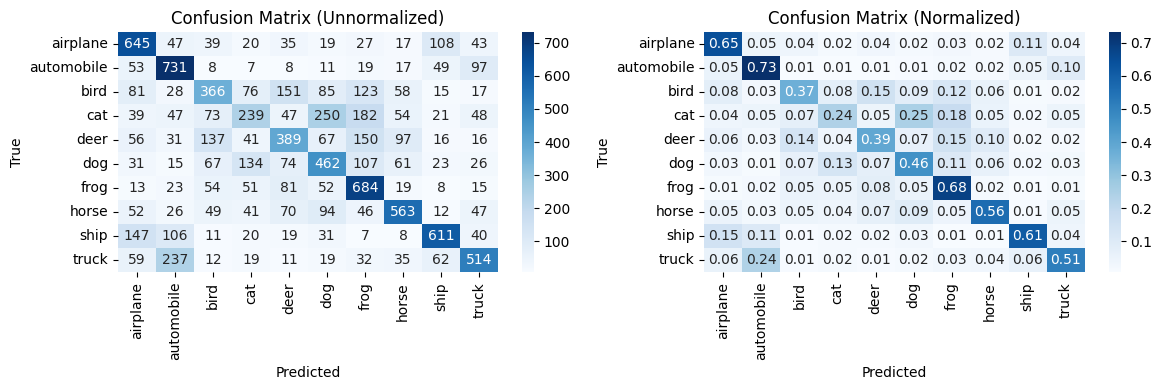


Randomly Select 10 Samples for Testing:


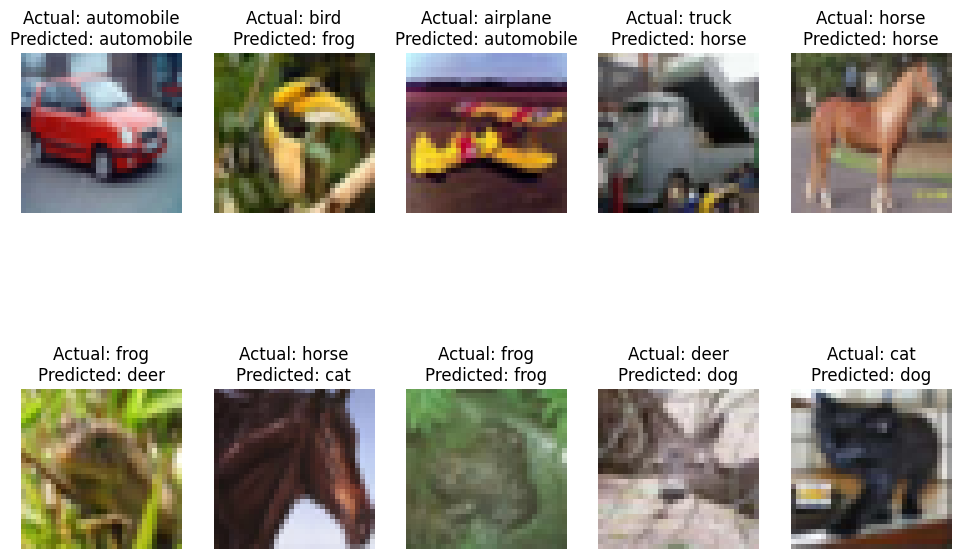

In [ ]:
# Main function to run the deep learning pipeline
def main(optimizer_option, batch_size):
    """
    Main function to run the model with specified optimizer.

    Args:
    - optimizer_option (may or may not be hardcoded)
    - batch size for training.
    """

    ##################### Define run parameters #########################################
    # Get datasets
    trainloader, valloader, testloader = get_datasets(transform, batch_size)

    # Initialize the model
    model = FCNet().to(device)

    # Select optimizer based on user's choice
    optimizer = select_optimizer(optimizer_option, model)

    # Define loss function
    criterion = nn.CrossEntropyLoss()

    # Lists to store training and validation accuracy
    train_accuracy_list = []
    val_accuracy_list = []

    # Set Number of epochs to train model for
    num_epochs = 10

    ####################################################################################


    # Train the model for multiple epochs
    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_model(model, trainloader, optimizer, criterion, device)
        val_accuracy = validate_model(model, valloader, device)

        # Append accuracy values to lists for later plotting
        train_accuracy_list.append(train_accuracy)
        val_accuracy_list.append(val_accuracy)

        print(f'Epoch {epoch + 1}, Loss: {train_loss}, Training Accuracy: {train_accuracy}%, Validation Accuracy: {val_accuracy}%')

    print('Finished Training')

    # Test the model
    test_accuracy, true_labels, predicted_labels = test_model(model, testloader, device)

    print(f'Test Accuracy: {test_accuracy}%')

    # Calculate classification report
    print(classification_report(true_labels, predicted_labels, target_names=class_names))

    # Create confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Plot unnormalized confusion matrix
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Unnormalized)')

    # Plot normalized confusion matrix
    normalized_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    plt.subplot(1, 2, 2)
    sns.heatmap(normalized_conf_matrix, annot=True, fmt='.2f', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Normalized)')
    plt.tight_layout()
    plt.show()

    # Randomly select 10 samples for testing
    print("")
    print("Randomly Select 10 Samples for Testing:")
    random_indices = random.sample(range(len(testloader.dataset)), 10)
    plt.figure(figsize=(12, 8))
    for i, idx in enumerate(random_indices):
        plt.subplot(2, 5, i + 1)
        image, label = testloader.dataset[idx]
        image = image / 2 + 0.5  # Unnormalize
        np_image = image.numpy()
        plt.imshow(np.transpose(np_image, (1, 2, 0)))
        actual_label = class_names[label]
        predicted_label = class_names[predicted_labels[idx]]
        plt.title(f'Actual: {actual_label}\nPredicted: {predicted_label}')
        plt.axis('off')
    plt.show()

if __name__ == "__main__":
    # Select the optimizer option
    #optimizer_option = input("Select optimizer option (adam,  momentum, SGD): ")

    optimizer_option = "SGD" #changed to an hardcoded version

    # Select the batch size for training
    batch_size = int(input("Enter batch size: "))
    main(optimizer_option, batch_size)

## 6 Questions and exercises

### 6.1 Exercises (40 points)

E1. Using the original file and variables, discuss the overall results of the training. Overall, the system did not do well with an accuracy of just over 50% and the confusion matrices given above. In what situations did the system perform poorly or better? Is the system overfit or underfit? Give two approaches that might help improve system performance based on the results.

E2. Implement one of your approaches in the code. Be sure to highlight what you did and describe it in words in this section. (you can change models, learning rates, optimization, add in regularization, train for different times,etc.) Comment on **why** you made each change. Give the setup that gave you the **best** results in your Python Notebook file with the run results saved.

E3. Compare the difference in the results obtained from two different optimizers. when might you choose one over the other, and why?

### 6.2 Conceptual Questions: (10 Points)

C1. A “loss landscape” of your neural network’s loss function has a plateau shape, in
which there are large areas where the loss is flat. This means the gradient signal will be weak and gradient descent will not update the network parameters very much in each iteration.

What are two activation functions that may cause such a problem, and one activation function that will not?

C2. Which methods may help accelerate the optimization of a model that uses batch gradient descent?
a. Using Adam.
b. Fine tuning the learning rate using grid search.
c. Initializing all the weights to zero.
d. Using mini-batch gradient descent.

C3. Compute the value of the function f(θ)=(θ-1)^4 after updating θ in one step of gradient descent, for θ = 4 and η=0.01. Does it look like the algorithm will converge to an optimum value of the function? Why or why not?

C4. Which statements are true about the step size in gradient descent?
a. The step size is the learning rate times the magnitude of the gradient.
b. If the step size is too big, gradient descent may oscillate leading to slow or unstable convergence.
c. The smaller the step size, the faster we can reach the optimal minima.

C5. State if each statement is true or false and give a brief reason

A). L2 regularization encourages sparse weights.

B) You notice that while training your neural network the test loss initially decreases
but then starts increasing, while training loss continues to decrease. This means
that test loss will only continue to increase if we train further.



In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

# Define a simple linear model
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.fc = nn.Linear(3 * 32 * 32, 10)  # 3 channels, 32x32 input size, 10 classes

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.fc(x)
        return x

# Data preprocessing and loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize data
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

# Initialize the model, loss function, and optimizer
net = LinearModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Training loop
for epoch in range(10):  # You may need to increase the number of epochs
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}")

# Testing the model
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy}%")


Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Loss: 1.8782083729039067
Epoch 2, Loss: 1.7784772437551748
Epoch 3, Loss: 1.7496900113342364
Epoch 4, Loss: 1.7311925022193537
Epoch 5, Loss: 1.718836709361552
Epoch 6, Loss: 1.7086176308219696
Epoch 7, Loss: 1.699905716854593
Epoch 8, Loss: 1.693524274374823
Epoch 9, Loss: 1.6880760070917857
Epoch 10, Loss: 1.6841408450280309
Test Accuracy: 41.29%


In [ ]:
import torch.nn as nn

class FCNetGenericConv(nn.Module):
    """
    A flexible fully connected neural network model with dynamic convolutional and fully connected layers.

    Attributes:
    - input_dim: Input dimension for the feature vector.
    - hidden_layers: List of dictionaries specifying hidden layers (convolutional or fully connected).
    - activations: List of activation functions for each hidden layer.
    - output_dim: Output dimension (number of classes).

    Methods:
    - __init__(input_dim, hidden_layers, activations, output_dim): Initializes the model.
    - forward(x): Defines the forward pass of the network.
    """

    def __init__(self, input_dim, hidden_layers, activations, output_dim):
        super(FCNetGenericConv, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.activations = activations

        # Create hidden layers (convolutional or fully connected) dynamically based on hidden_layers
        self.hidden_layers = []
        for layer_params in hidden_layers:
            layer_type = layer_params['type']
            if layer_type == 'conv':
                in_channels = layer_params['in_channels']
                out_channels = layer_params['out_channels']
                kernel_size = layer_params['kernel_size']
                padding = layer_params['padding']
                self.hidden_layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding))
            elif layer_type == 'fc':
                in_features = layer_params['in_features']
                out_features = layer_params['out_features']
                self.hidden_layers.append(nn.Linear(in_features, out_features))
            else:
                raise ValueError(f"Unsupported layer type: {layer_type}")
            self.hidden_layers.append(activations.pop(0))  # Apply activation after each layer

        # Create the output layer
        self.output_layer = nn.Linear(hidden_layers[-1]['out_features'], output_dim)

    def forward(self, x):
        """
        Defines the forward pass of the fully connected neural network.

        Args:
        - x: Input feature vector.

        Returns:
        - x: Output tensor representing class scores.
        """
        x = x.view(-1, 3, 32, 32)  # Reshape the input tensor to (batch_size, 3, 32, 32)
        for layer in self.hidden_layers:
            x = layer(x)
        x = x.view(x.size(0), -1)  # Flatten the convolutional output
        x = self.output_layer(x)  # Apply the output layer
        return x

# Define hyperparameter cases
hyperparameter_cases = [
    {
        'hidden_layers': [
            {'type': 'fc', 'in_features': 3 * 32 * 32, 'out_features': 512},
            {'type': 'fc', 'in_features': 512, 'out_features': 256},
            {'type': 'fc', 'in_features': 256, 'out_features': 128}
        ],
        'activations': [nn.ReLU(), nn.ReLU(), nn.ReLU()],
        'learning_rate': 0.001,
        'optimizer': 'adam'
    },
    # Add more hyperparameter cases here
    {
        'hidden_layers': [
            {'type': 'fc', 'in_features': 3 * 32 * 32, 'out_features': 256},
            {'type': 'fc', 'in_features': 256, 'out_features': 128}
        ],
        'activations': [nn.ReLU(), nn.ReLU()],
        'learning_rate': 0.01,
        'optimizer': 'sgd'
    }
]

# Loop through the hyperparameter cases and create models
for case in hyperparameter_cases:
    model = FCNetGenericConv(
        input_dim=3 * 32 * 32,
        hidden_layers=case['hidden_layers'],
        activations=case['activations'],
        output_dim=10  # Number of output classes for CIFAR-10
    )

    # Print the model and hyperparameters
    print(f"Model: {model}")
    print(f"Learning Rate: {case['learning_rate']}")
    print(f"Optimizer: {case['optimizer']}")
    print("-" * 20)  # Separator between cases


Model: FCNetGenericConv(
  (output_layer): Linear(in_features=128, out_features=10, bias=True)
)
Learning Rate: 0.001
Optimizer: adam
--------------------
Model: FCNetGenericConv(
  (output_layer): Linear(in_features=128, out_features=10, bias=True)
)
Learning Rate: 0.01
Optimizer: sgd
--------------------


In [15]:
# Given values
theta_old = 4
eta = 0.01

# Compute the gradient of the function
gradient = 4 * (theta_old - 1) ** 3

# Update theta
theta_new = theta_old - eta * gradient

# Compute the new function value
function_value = (theta_new - 1) ** 4

theta_new, function_value


(2.92, 13.589544959999998)